# Task 2: 了解数据，数据诊断

## 导言

在了解个人业务的基本业务情况之后，接下来需要了解个人业务基础数据结构。在实际工作中，我们遇到的数据往往是原始数据，这些数据一般都不是清晰完整的，比如可能出现数据缺失，ID不唯一的情况，不能直接用来建模。数据诊断工作帮助我们了解数据的缺陷，以便进一步的清理和整合数据。
数据诊断可以从完整性，准确性，合理性等多个方面入手，诊断手段包括但不限于以下几种，比如单个变量的诊断，多个变量之间关系的诊断，不同表之间关系的诊断。下面举几个诊断的例子，让大家对于数据诊断工作有个感性的认识。

1. 首先是单变量的完整性问题。有的客户的信用分数有缺失的，这种情况可能因为数据抽过程中数据缺失了，也有可能是这个客户本身在信用局就没有信用记录，需要区分这两种情况，代表的含义是不一样的。如果建模数据中有缺失值，就无法通过逻辑回归算法进行建模，必须将缺失值补全，或者删除有缺失值的记录，才能进行正常的建模。
2. 其次是通过多个变量关系发现数据准确性问题。比如分析客户职业和收入数据关系，发现有的客户是正常的公司管理人员，并不是失业状态，但是收入填写的是年收入30元，有可能因为用户不愿透漏收入情况，也有可能是因为少填了“万”字，虽然这种数据没有缺失，但是也是不准确的。
3. 还有通过表之间关联分析发现数据不合理的问题。比如在诊断交易账单表和客户表的关系时，可能会发现，在客户表里出现的客户号，没有在交易账户里出现过，这是合理的，因为有些客户开卡之后，并没有交易，所以在交易账单表里没有出现；但是如果在交易账单表里面的客户号，却没有出现在客户表里，就不合理了，任何一个正式用户都应该在客户表里保存，否则不可能进行正常的交易，这些不合理的客户需要从建模的样本剔除。

在做数据诊断的过程中，一方面需要对于数据进行多方位统计，另一方面需要识别数据问题，这就需要理解业务流程和常识。在实际工作中，如果遇到不能理解的数据问题和特殊情况，需要及时和业务方沟通，了解实际情况，做到心中有数。

### 环境准备
载入所需R包：

In [1]:
library(data.table)
library(tidyverse)
library(mlr)

Warning message:
"package 'data.table' was built under R version 4.0.3"
Warning message:
"package 'tidyverse' was built under R version 4.0.2"
Warning message:
"replacing previous import 'vctrs::data_frame' by 'tibble::data_frame' when loading 'dplyr'"
-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

√ ggplot2 3.3.2     √ purrr   0.3.4
√ tibble  3.0.1     √ dplyr   1.0.0
√ tidyr   1.1.0     √ stringr 1.4.0
√ readr   1.3.1     √ forcats 0.5.0

Warning message:
"package 'ggplot2' was built under R version 4.0.2"
Warning message:
"package 'tidyr' was built under R version 4.0.2"
Warning message:
"package 'readr' was built under R version 4.0.2"
Warning message:
"package 'dplyr' was built under R version 4.0.2"
Warning message:
"package 'forcats' was built under R version 4.0.2"
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::between()   masks data.table::between()
x dplyr::filter()    masks stats::filter()
x dplyr:

### Step 1: 读入数据
待处理数据以csv文件给出，数据字典以xlsx文件给出。设定当前路径到数据所在文件夹，读取数据：

In [2]:
# set path
sw <- "E:/实习/信用卡管理/Task 2"
setwd(sw) 
path <- paste(sw, "data", sep = "/")
filepath <- list.files(path = path, pattern = ".csv", full.names = TRUE)
filename <- gsub(pattern = ".csv", replacement = "", 
                 list.files(path = path, pattern = ".csv"))
# read data
for (i in 1:length(filepath)) {
  assign(filename[i], fread(input = filepath[i]) %>% as_tibble())
}

### Step 2:数据去重
**1. 客户表(app_data)处理思路**  

app_data中的客户号应具有唯一性，首先针对ID列进行数据去重。经检查发现，有8个ID出现了2次，其中有5条数据是重复的，删除。其余3条数据仅与其同ID的数据在字段“AMT_INCOME_TOTAL”不同，均相差一位0，考虑是数据采集或录入出错，采取删除操作

In [3]:
# 查看原始数据样本数
nrow(app_data)

[1] 4058

In [4]:
# 查看重复值
dup_id <- app_data %>% group_by(ID) %>% mutate(count = n()) %>% filter(count > 1) %>% ungroup()
dup_id

ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,count
<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<int>,<int>
5760331,M,Y,N,0,81000,State servant,Secondary / secondary special,Single / not married,Municipal apartment,-10574,-126,1,0,0,0,Drivers,1,2
5760331,M,Y,N,0,81000,State servant,Secondary / secondary special,Single / not married,Municipal apartment,-10574,-126,1,0,0,0,Drivers,1,2
5465597,F,N,Y,1,157500,Working,Secondary / secondary special,Married,House / apartment,-12108,-1379,1,0,0,0,Sales staff,3,2
5465597,F,N,Y,1,157500,Working,Secondary / secondary special,Married,House / apartment,-12108,-1379,1,0,0,0,Sales staff,3,2
5787586,M,Y,Y,2,180000,Working,Higher education,Civil marriage,House / apartment,-14708,-1679,1,0,1,0,Laborers,4,2
5787586,M,Y,Y,2,18000,Working,Higher education,Civil marriage,House / apartment,-14708,-1679,1,0,1,0,Laborers,4,2
5992966,M,Y,Y,0,135000,Working,Secondary / secondary special,Civil marriage,House / apartment,-16857,-1682,1,0,0,1,Managers,2,2
5992966,M,Y,Y,0,13500,Working,Secondary / secondary special,Civil marriage,House / apartment,-16857,-1682,1,0,0,1,Managers,2,2
5090598,F,N,Y,0,112500,State servant,Higher education,Married,House / apartment,-16907,-429,1,0,0,0,Secretaries,2,2


In [5]:
dup_data <- dup_id[!duplicated(dup_id),]

# 因为已经group过，所以每一个ID重复的数据都和它的上一条数据做对比
diff_col <- list()
for (i in which(duplicated(dup_data$ID,))) {
  diff_col <- append(diff_col, colnames(dup_data)[which(dup_data[i, ] != dup_data[(i-1), ])])
}

# 查看相同ID的数据哪些字段取值不同
diff_col

[[1]]
[1] "AMT_INCOME_TOTAL"

[[2]]
[1] "AMT_INCOME_TOTAL"

[[3]]
[1] "AMT_INCOME_TOTAL"

In [6]:
# 发现其余3条ID重复的数据均在AMT_INCOME_TOTAL上有差异，查看发现都是少了一位0，
# 判断为数据采集或者录入错误，删除ID重复数据。
app_data <- app_data[!duplicated(app_data$ID), ]
nrow(app_data)

[1] 4050

说明：去重之后的客户表(app_data)含有4050条数据，18个特征。

**2. 交易表(app_data)处理思路**

trans中账户号不具有唯一性，因为一个账户可以进行多次交易，只需查看是否有整条重复数据。

In [7]:
trans <- trans[!duplicated(trans), ]
print(paste("trans中的记录条数:", nrow(trans)))

print(paste("trans中发起交易的账户数:", length(unique(trans$account_id))))

[1] "trans中的记录条数: 1056214"
[1] "trans中发起交易的账户数: 4491"


说明：去重之后的交易表(trans)共计4491个账户发起了1056214次交易，含10个特征，其中字段account和bank意义不明，后续考虑删除。

### **Step 3: 了解数据**

**Q1.** 尝试对项目中提供的数据进行单变量诊断，生成诊断检查统计表.

**1. 客户表处理事项**：针对app_data进行单变量诊断，将结果输出保存到文件中。

R中有很多函数支持数据概览，`mlr`包中的`summarizeColumns()`函数输出结果更全面，也更易读，输出内容包含变量名，变量类型，缺失值数量，均值，中位数，标准差，最大值，最小值等等。

In [8]:
summary_app <- summarizeColumns(app_data)

**(1) 分类变量**

In [9]:
# 查找分类变量
cate_feature_app <- summary_app$name[summary_app$type == "character"]
FLAG <- colnames(app_data)[grep("FLAG", colnames(app_data))]
cate_feature_app <- union(cate_feature_app, FLAG)

# 分类变量的汇总情况输出保存至文件summary_cate.txt.
for (fea in cate_feature_app) {
  sink(paste(sw, "summary_cate.txt", sep = "/"), append = TRUE)
  cat("The distribution of", fea, ": \n")
  count <- table(app_data[[fea]], useNA = "ifany")
  tab <- cbind(count = count, 
               freq  = round(count / nrow(app_data), 3))
  tab <- as.data.frame(tab)
  print(tab)
  cat("\n")
  sink()
}

汇总分类变量的频次与百分比：

| 变量名        | 类别        | 计数    | 频率        |
|:------------------|:----------------|:----------|:-----------------|
|    性别       | - 男       | - 1387   |  - 65.8%    |
|             | - 女       | - 2663   |  - 34.2%    |
| 是否有车      | - 否       |  2531   |  62.5%     |
|               | - 是       |  1519   |  37.5%     |
| 是否有房产    | - 否       |  1260   |  31.1%     |
|               | - 是       |  2790   |  68.9%     |
| 收入类别      | - 商业     |  905    | 22.3%    |
|               | - 退休金   |  719    | 17.8%    |
|               | - 公务员   |   328    | 8.1%     |
|               | - 务工     |  2098   | 51.8%    |
| 教育程度      | - 学位     |  4      | 0.1%     |
|               | - 高中     |  1058   | 26.1%    |
|               | - 高中肄业 |  140    | 3.5%     |
|               | - 初中     |  42     | 1.0%     |
|               | - 初中专项 |  2806   | 69.3%    |
| 婚姻状态      | - 公证婚姻 |  355    | 8.8%     |
|               | - 已婚     |  2750   | 67.9%    |
|               | - 离异     |  237    | 5.9%     |
|               | - 未婚     |  544    | 13.4%    |
|               | - 丧偶     |  164    | 4.0%     |
| 居住方式      | - 合住公寓 |  13     | 0.3%     |
|               | - 公寓     |  3652   | 90.2%    |
|               | - 市政公寓 |  127    | 3.1%     |
|               | - 写字楼   |  42     | 1.0%     |
|               | - 租房     |  60     | 1.5%     |
|               | - 与父母同住| 156    | 3.9%     |
| 职业类型      | - 会计师    | 150    | 3.7%     |
|               | - 清洁工    | 39     | 1.0%     |
|               | - 厨师      | 51     | 1.3%     |
|               | - 核心员工  | 386    | 9.5%     |
|               | - 司机      | 229    | 5.7%     |
|               | - 高级技工  | 174    | 4.3%     |
|               | - 人力资源  | 7      | 0.2%     |
|               | - 互联网    | 5      | 0.1%     |
|               | - 工人      | 708    | 17.5%    |
|               | - 低技能工人| 17     | 0.4%     |
|               | - 管理者    | 338    | 8.3%     |
|               | - 医务工作者| 104    | 2.6%     |
|               | - 私人服务者| 37     | 0.9%     |
|               | - 不动产代理人 |2      | 0.0%     |
|               | - 销售人员   |384    | 9.5%     |
|               | - 秘书        |21     |0.5%     |
|               | - 安保人员    |83     |2.0%     |
|               | - 服务员      |16     |0.4%     |
|               | - 未知        |1299   |32.1%    |
| 是否有手机    | - 否          |0      |0.0%     |
|               | - 是          |4050   |100.0%   |
| 是否有工作电话| - 否          |3223   |79.6%    |
|               | - 是          |827    |20.4%    |
| 是否有电话    | - 否          |2905   |71.7%    |
|               | - 是          |1145   |28.3%    |
| 是否有Email       | - 否          |3601   |88.9%    |
|               | - 是          |449    |11.1%    |


根据该表来看，除了“职业类型”有30%以上的未知类型，其余变量没有缺失值和未知值。 客户中男性占比较高，且多数申请人无房或无车，务工群体占一半，教育程度偏低。 其中，“居住方式”的分布严重倾斜，90%以上是公寓房，后续需要合并类别或删除； “是否有手机”是常数变量，在后续处理中需要删除。

**(2)连续变量**

In [10]:
# 查找连续变量
cont_feature_app <- setdiff(colnames(app_data), c(cate_feature_app, "ID")) # exclude ID
# summary_app[summary_app$name %in% cont_feature_app, ]

# 连续变量的汇总情况输出保存至文件summary_cont.csv.
write.csv(summary_app[summary_app$name %in% cont_feature_app, ], 
            file = paste(sw, "summary_cont.csv", sep = "/"), 
            row.names = FALSE)

汇总连续变量的描述性统计特征： 

|  变量名       |  缺失样本数  | 均值   |   标准差   |  中位数   |   最小值   |    最大值 |
|----------------- |-------------|----------|------------- |-------------|-------------|-----------|
| 孩子个数      | 	  0    |     0.41	 |    0.70       |    0         |   0	      |     4      |
| 年总收入      | 	 0     |  191048.20  | 148035.07     |162000        |   27000     |  6750000   |
| 生日          |     0	 | -16107.04 |  4159.09      |  -15875.5      |   -25080    |      -8050 |
| 开始工作日期  |    0     |   62348.55	 |140281.54   |-1460.5        |  -16220       |365243    |
| 家庭人数      |    0     |      2.18	 |   0.87        |   2          |     1       |     6    |

 从上表看出，连续变量数据完整，没有缺失。申请人多数是没有孩子的, “年总收入”平均在19万左右，但是差异明显，其中最小值为2.7万，最大的有675万。

**2. 交易表处理事项**：针对trans进行单变量诊断，将结果输出保存到文件中。过程同上。

In [11]:
summary_trans <- summarizeColumns(trans)

# 查找分类变量
cate_feature_trans <- summary_trans$name[summary_trans$type == "character"]

# 分类变量的汇总情况输出保存至summary_cate_trans.txt
for (fea in cate_feature_trans) {
  sink(paste(sw, "summary_cate_trans.txt", sep = "/"), append = TRUE)
  cat("The distribution of", fea, ": \n")
  count <- table(trans[[fea]], useNA = "ifany")
  tab <- cbind(count = count, 
               freq  = round(count / nrow(trans), 3))
  tab <- as.data.frame(tab)
  print(tab)
  cat("\n")
  sink()
}

# 查找连续变量
cont_feature_trans <- setdiff(colnames(trans), c(cate_feature_trans, "trans_id", "account_id", "date")) 
# summary_trans[summary_trans$name %in% cont_feature_trans, ]

# 连续变量的汇总情况输出保存至文件summary_cont_trans.csv.
write.csv(summary_trans[summary_trans$name %in% cont_feature_trans, ], 
          file = paste(sw, "summary_cont_trans.csv", sep = "/"), 
          row.names = FALSE)

Warning message in mde(x):
"强制改变过程中产生了NA"


汇总trans表中分类变量的频次与百分比：

| 变量名        | 类别          | 计数        | 频率        |
|:------------------|:------------------|:------------|:-------------------|
| 借贷类型      | - 贷方        |   421677    |    39.9%    |
|  (type)        | -  借方        |   634537    |    60.1%    |
| 交易类型      | -  现金        |   434884    |   41.2%     |
| (operation)      | -  信用卡      |   8036      |   8.0%      |
|               |  - 收款        |   65226     |   6.2%      |
|               |   - 贷款        |   156671    |   14.8%     |
|               |   - 汇款        |   208283    |   19.7%     |
|               |   - 未知        |   183114    |   17.3%     |
| 交易特征      |   - 养老金      |   30338     |   2.9%      |
| (k_symbol)     |    - 支付         |   155832    |   14.8%     |
|               |   - 保险交易    |   18500     |   1.7%      |
|               |  - 利息        |   184691    |   17.5%     |
|               |   - 贷款交易    |   13580     |   1.3%      |
|               |   - 房贷        |   118065    |   11.2%     |
|               |   - 未知        |   535208    |   50.6%     |
| 银行          |   - AB          |   21720     |   2.1%      |
| (bank)         |    - CD          |   19597     |   1.9%      |
|               |   - EF          |   21293     |   2.0%      |
|               |  - GH          |   21499     |   2.0%      |
|               |  - IJ          |   20525     |   1.9%      |
|               |  - KL          |   21234     |   2.0%      |
|               |  - MN          |   19623     |   1.9%      |
|               |  - OP          |   21094     |   2.0%      |
|               |  - QR          |   22285     |   2.1%      |
|               |  - ST          |   21711     |   2.1%      |
|               |  - UV          |   21167     |   2.0%      |
|               |  - WX          |   20178     |   1.9%      |
|               |  - YZ          |   21582     |   2.0%      |
|               |  - 未知        |   782706    |   74.1%     |


根据该表，交易表中带来类型以借方类型较多，交易类型以现金交易最多，信用卡和收款交易较少。“交易特征”有50%以上的未知量，该特征很重要，保留未知量。“银行”有74%的未知特征，由于该字段表意不明且未知数过多，后续建模考虑删除。


**(2)** 连续变量的统计量汇总如下。

|  变量名   |  缺失样本数    |  均值    |    标准差    |    中位数  | 最小值   |    最大值  |
|:-----------:|:----------------:|:----------:|:------------:|:------------:|:---------:|:-----------:|   
|   账目	  |  760825(72%)	| 45670919	  |30663397	|   45750951     |  0	    |  99994199 |
|   金额   |    0	       |  5924.50	  |  9523.08	|  2100	      |    0	 |  87400  |
|  账户余额  |    0	       |  38520.48	  |22117.85	   |  33146	      |-41126	  | 209637  |
  
  
账目(account)是一种数字编码，取值不表示大小，该字段本身字段没有意义，且有70%以上的数据缺失，在后续建模中可以剔除。重点关注金额和账户余额两个特征。"交易金额"约有一半的交易金额实际上小于2100，最大值达到87400， 分布明显右偏。"账户余额"跨度大，分布右偏，余额为负的客户不多, 个别账户具有高余额。


**Q2:** 分析app_data和trans中ID分布的匹配程度，即两张表中共同出现ID的个数，以及只在各自数据集中出现的ID个数。

**思路：** 统计只在客户表(app_data)或交易表(trans)中出现的账户号account_id, 参照link_table中的两个字段ID和account_id，进行表格间的连接。
首先将客户表(app_data)与link_table内连接，匹配出客户表中的account_id. 

In [12]:
# 参照link_table做表格内连接
app_join_link <- inner_join(app_data, link_table, by = "ID") %>% 
  select(ID, account_id, everything())

# 在客户表中出现且没有在交易表中出现的account_id,说明只有客户号，没有交易过。
app_no_trans <- setdiff(app_join_link$account_id,trans$account_id)
print(paste("the account_id only appear in app_data:", length(app_no_trans)))

# 在交易表中出现但没有在申请表中出现的account_id,说明没有开账户就进行了交易。
trans_no_app <- setdiff(trans$account_id, app_join_link$account_id)
print(paste("the account_id only appear in trans:", length(trans_no_app)))

# 在两张表中都出现的account_id数量
trans_with_app <- intersect(trans$account_id, app_join_link$account_id)
print(paste("the account_id appear in both data:", length(trans_with_app)))

[1] "the account_id only appear in app_data: 8"
[1] "the account_id only appear in trans: 449"
[1] "the account_id appear in both data: 4042"


汇总成表：
   
 |  表名        | account_id计数 |        
 |-----------------|----------------|   
 |只在客户表中出现 |      8	    |
 |只在交易表中出现 |     449    |
 |同时出现       |	    4042   |
 
在客户表中出现但没有在交易表中出现的account_id有8个，说明这8位客户没有交易过。然而有449个账户在客户表并没有申请记录且进行了交易，存在异常，在后续建模中考虑删除。另外的4042个账户都是开通后进行正常交易的，是在后续建模可以正常使用的数据。

**Q3:** 诊断数据中的异常值。

我们将异常值定义为在均值的3倍标准差之外的值，对客户表和交易表中的连续变量进行异常值识别。

In [13]:
find_outliers <- function(data, fea) {
  
  data_mean  <- mean(data[[fea]])
  lower_rule <- data_mean - sd(data[[fea]]) * 3
  upper_rule <- data_mean + sd(data[[fea]]) * 3
  outliers_ind <- (data[[fea]] > upper_rule) | (data[[fea]] < lower_rule)

  return(which(outliers_ind))
}

**1. 客户表(app_data)连续型数据诊断：**

In [14]:
# 针对app_data
app_cont_outlier <- list()
for (f in 1:length(cont_feature_app)) {
  app_cont_outlier[[f]] <- find_outliers(app_data, cont_feature_app[f])
} 
names(app_cont_outlier) <- cont_feature_app
lapply(app_cont_outlier, function(item) {length(item)})

cat("outlier values of CNT_CHILDREN:", unique(app_data$CNT_CHILDREN[app_cont_outlier[["CNT_CHILDREN"]]]), "\n")
cat("outlier values of CNT_FAM_MEMBERS:", unique(app_data$CNT_FAM_MEMBERS[app_cont_outlier[["CNT_FAM_MEMBERS"]]]), "\n")
cat("outlier values of AMT_INCOME_TOTAL:", unique(app_data$AMT_INCOME_TOTAL[app_cont_outlier[["AMT_INCOME_TOTAL"]]]), "\n")

$CNT_CHILDREN
[1] 54

$AMT_INCOME_TOTAL
[1] 28

$DAYS_BIRTH
[1] 0

$DAYS_EMPLOYED
[1] 0

$CNT_FAM_MEMBERS
[1] 53

outlier values of CNT_CHILDREN: 3 4 
outlier values of CNT_FAM_MEMBERS: 5 6 
outlier values of AMT_INCOME_TOTAL: 675000 810000 652500 990000 1350000 1125000 742500 720000 9e+05 765000 787500 828000 1575000 6750000 


分析“小孩个数”和“家庭人数”两个字段。大多数客户拥有在2个或2个以下的孩子，仅54人有3个或3个以上的孩子。“家庭人数”与“孩子个数”保持一致，除一位40岁男性申请人，未婚但有3个孩子，但该客户在交易表中没有交易记录, 对交易数据的分析不会产生影响。

分析"年总收入"。绘制"年总收入"的密度图，发现数据严重右偏，拖尾严重： 

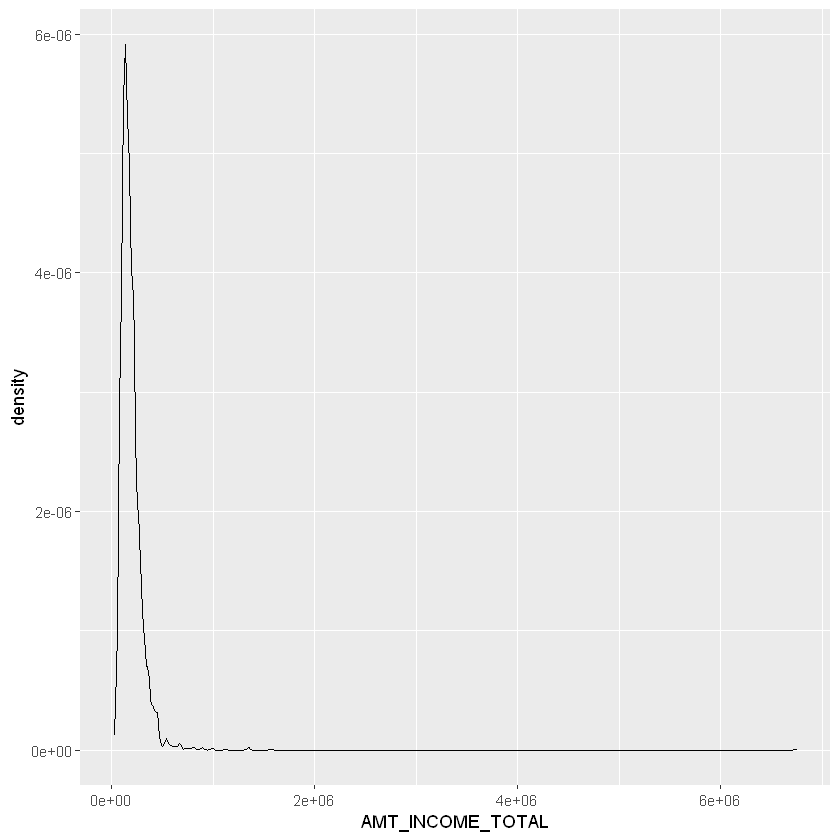

In [15]:
library(ggplot2)
ggplot(data = app_data) +  geom_density(mapping = aes(x = AMT_INCOME_TOTAL)) 

下面检查**年总收入最值**的合理性。

[1] "年总收入最小的客户信息："


ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<int>
5213636,F,N,N,0,27000,Pensioner,Secondary / secondary special,Widow,House / apartment,-20935,365243,1,0,0,0,,1


[1] "年总收入最大的客户信息："


ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<int>
5987964,M,Y,N,0,6750000,Working,Higher education,Married,House / apartment,-19341,-443,1,1,1,0,Laborers,2


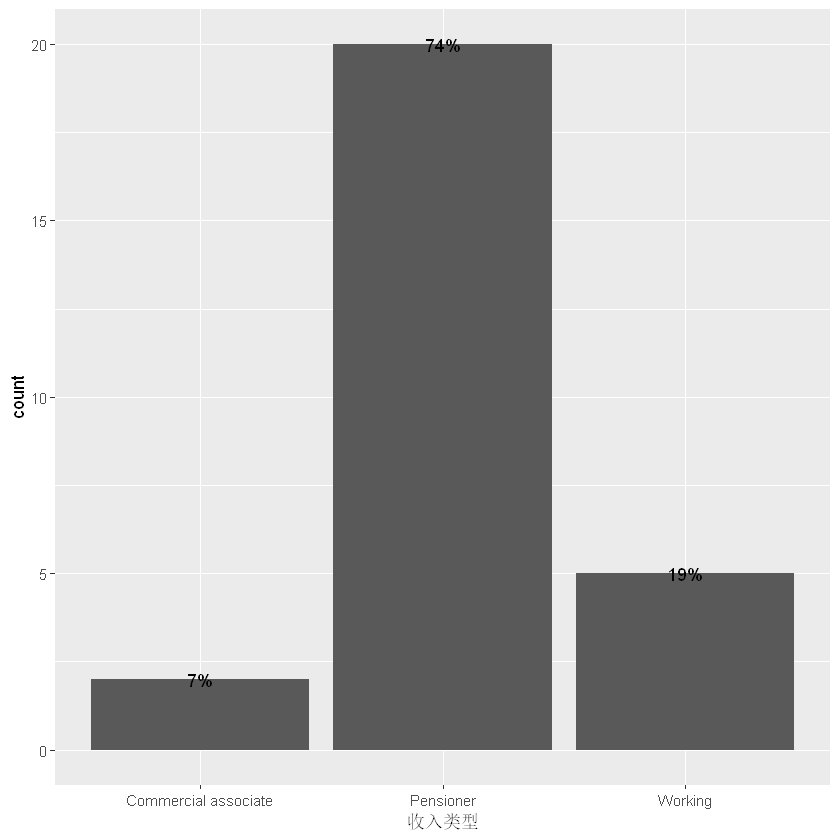

In [16]:
# 查看年总收入最小的客户
print("年总收入最小的客户信息：")
app_data[which(app_data$AMT_INCOME_TOTAL == min(app_data$AMT_INCOME_TOTAL)), ]

# 年收入低于5万的人群
dd <-  app_data[app_data$AMT_INCOME_TOTAL < 50000, ]
ggplot(data = dd) + geom_bar(mapping = aes(x = NAME_INCOME_TYPE)) + 
  xlab("收入类型") + geom_text(aes(x = NAME_INCOME_TYPE, label =  scales::percent((..count..)/sum(..count..))), stat="count")

# 查看年总收入最大的客户
print("年总收入最大的客户信息：")
app_data[which(app_data$AMT_INCOME_TOTAL == max(app_data$AMT_INCOME_TOTAL)), ]

最小年收入为27000，该客户为女性，丧偶，没有小孩，独居，58岁，主要收入为养老金(Pensioner)。且在年收入低于5万的人群中有74%的"收入类型"为养老金，因此该数据合理。最大年收入为675万，该申请人为男性，已婚，没有小孩，40岁，名下无房产，收入类型为工人(working)，职位为普通工人。根据其收入类型、职位和房产情况，推测该条数据存在异常。

进一步，绘制**"收入类型"**对**年总收入**的箱线图如下：

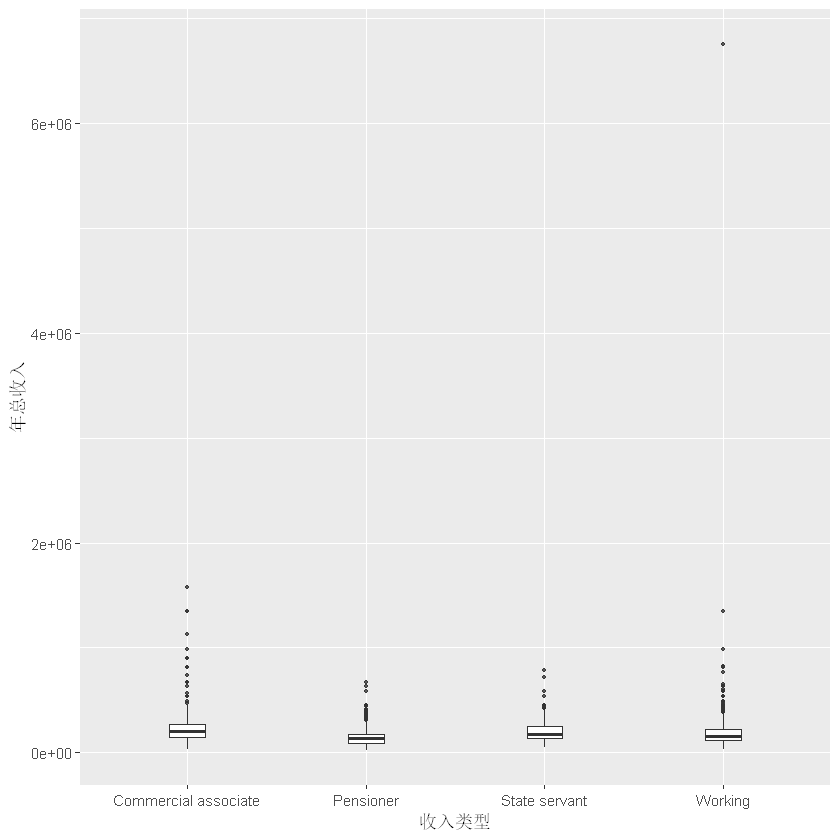

In [17]:
ggplot(data = app_data) + 
  geom_boxplot(mapping = aes(x = NAME_INCOME_TYPE , y = AMT_INCOME_TOTAL), width=.2, 
               outlier.size = .8, outlier.alpha = 0.8) + 
  xlab("收入类型") +
  ylab("年总收入")

可以发现675万的年收入在工人中确实属于异常点，应该是数据采集出错，后续会采用"Working"收入类型的年总收入均值填充。

In [18]:
# 按照"收入类型"汇总年总收入的均值和中位数.
app_data %>% filter(AMT_INCOME_TOTAL != 6750000) %>% 
  group_by(NAME_INCOME_TYPE) %>% 
  mutate(AVG_INCOME = mean(AMT_INCOME_TOTAL)) %>% 
  mutate(MED_INCOME = median(AMT_INCOME_TOTAL)) %>% 
  select(NAME_INCOME_TYPE, AVG_INCOME, MED_INCOME) %>%
  unique()

NAME_INCOME_TYPE,AVG_INCOME,MED_INCOME
<chr>,<dbl>,<dbl>
Working,184718.3,157500
Commercial associate,225170.8,202500
State servant,200455.3,180000
Pensioner,153145.8,135000


In [19]:
# 对其余几个年总收入的异常值，提取数据，考察其合理性.
app_data[app_cont_outlier[["AMT_INCOME_TOTAL"]], ] %>% 
  filter(AMT_INCOME_TOTAL != 6750000) 

ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<int>
5625145,M,Y,N,1,675000,Commercial associate,Higher education,Married,House / apartment,-11246,-148,1,0,1,0,Managers,3
5742478,M,N,Y,0,810000,Commercial associate,Higher education,Single / not married,House / apartment,-12164,-1514,1,1,0,1,Managers,1
6048499,M,Y,Y,0,652500,Working,Secondary / secondary special,Single / not married,House / apartment,-12657,-1522,1,0,0,1,Laborers,1
6087430,M,Y,Y,2,990000,Commercial associate,Higher education,Married,With parents,-12870,-1514,1,0,0,0,Managers,4
5889952,M,Y,N,3,1350000,Commercial associate,Higher education,Married,House / apartment,-13505,-2376,1,1,0,1,Managers,5
5290174,F,Y,Y,2,1125000,Commercial associate,Higher education,Married,House / apartment,-14030,-1532,1,0,0,1,Managers,4
5270822,M,Y,N,0,1350000,Working,Secondary / secondary special,Married,House / apartment,-14047,-1038,1,0,0,0,Managers,2
5290822,M,Y,N,0,810000,Working,Higher education,Married,Municipal apartment,-14305,-2401,1,0,0,0,Managers,2
5712749,F,N,Y,1,810000,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-14843,-4297,1,1,0,0,Managers,3


发现最后一条数据的"DAYS_EMPLOYED"记录为正值(应为负值，表示从申请日前推到开始工作日期之间的间隔)，且数值大于DAY_BIRTH)，考虑为记录错误，应清除该客户的"DAYS_EMPLOYED"字段。

此外，可以发现这些高收入人群大多从事商业活动(Commercial associate)且均为管理层(Managers)或核心员工(core staff)或高级技术人员(High skill tech staff)，但有少数从事工人(Working)，我们单独筛选出来分析。

In [20]:
app_data[app_cont_outlier[["AMT_INCOME_TOTAL"]], ] %>% 
  filter(AMT_INCOME_TOTAL != 6750000) %>%
  filter(NAME_INCOME_TYPE == "Working")

ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<int>
6048499,M,Y,Y,0,652500,Working,Secondary / secondary special,Single / not married,House / apartment,-12657,-1522,1,0,0,1,Laborers,1
5270822,M,Y,N,0,1350000,Working,Secondary / secondary special,Married,House / apartment,-14047,-1038,1,0,0,0,Managers,2
5290822,M,Y,N,0,810000,Working,Higher education,Married,Municipal apartment,-14305,-2401,1,0,0,0,Managers,2
5679647,M,Y,Y,1,990000,Working,Higher education,Married,House / apartment,-15634,-4563,1,1,0,0,,3
5834540,F,N,N,0,765000,Working,Higher education,Separated,House / apartment,-16617,-2454,1,1,0,0,Accountants,1
6636102,M,Y,N,0,828000,Working,Secondary / secondary special,Married,Municipal apartment,-17348,-2919,1,0,1,0,Managers,2


从上表看有3个从事Working的人职位为Managers，暂认为其收入无异常。有1个从事Working的人职位为Labors，但是有房有车，暂认为无异常。还有一位职位数据缺失，但有房有车，已婚已育比较稳定，暂时认为无异常。

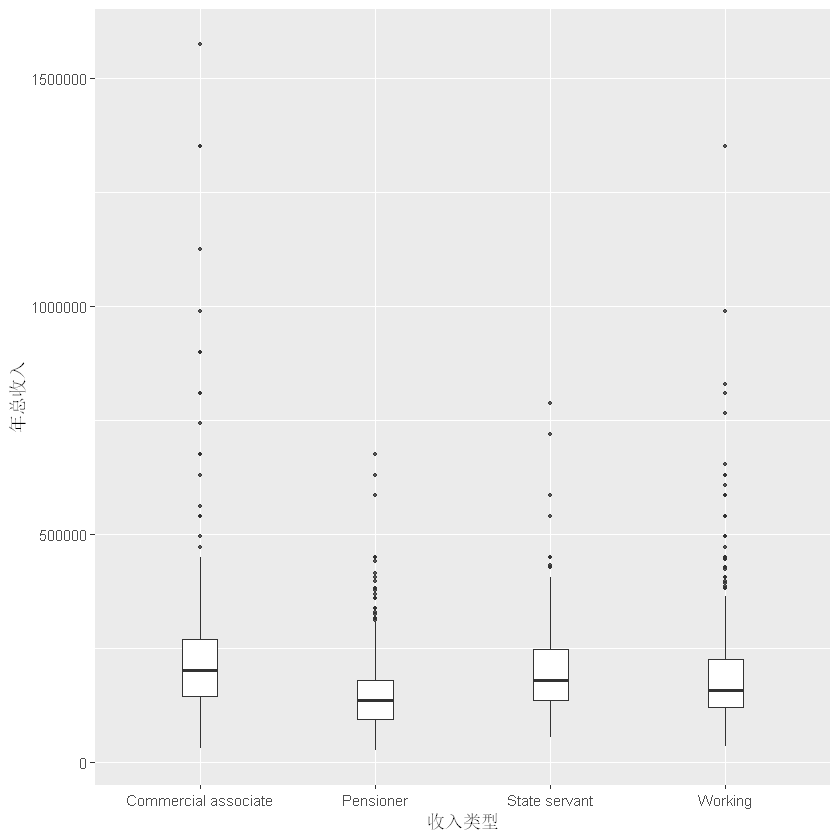

In [21]:
# 去除异常收入后更新箱线图：
app_data_new <- app_data %>% filter(AMT_INCOME_TOTAL != 6750000)
ggplot(data = app_data_new) + 
  geom_boxplot(mapping = aes(x = NAME_INCOME_TYPE , y = AMT_INCOME_TOTAL), width=.2, 
               outlier.size = .8, outlier.alpha = 0.8) + 
  xlab("收入类型") +
  ylab("年总收入")

通过以上分析，将两个明显的异常值更换为对应的收入类型下该字段的均值：

In [22]:
## Working下年总收入的均值
app_data$AMT_INCOME_TOTAL[app_data$AMT_INCOME_TOTAL == 6750000] <- 184718 

## Pensioner下工作天数的均值
app_data$DAYS_EMPLOYED[app_data$DAYS_EMPLOYED == 365243] <-
  mean(app_data$DAYS_EMPLOYED[app_data$NAME_INCOME_TYPE == "Pensioner" & app_data$DAYS_EMPLOYED < 0])

**2. 交易表(trans)异常诊断**

主要查看"金额"与"账户余额"的分布情况，检查是否存在异常值。

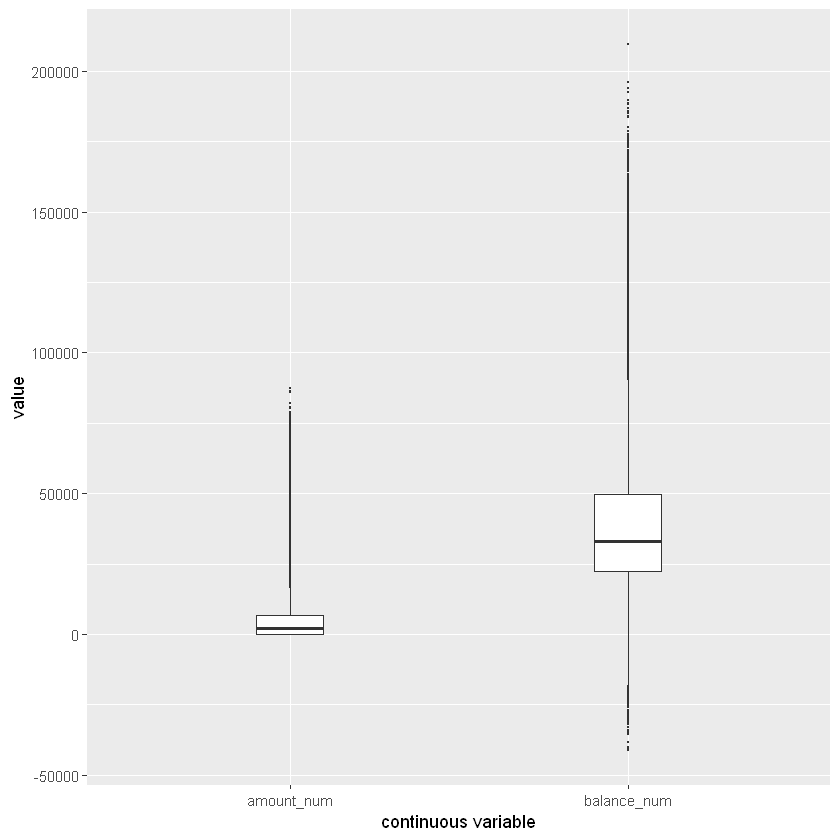

In [23]:
# 针对trans
trans_cont_outlier <- list()
for (f in 1:length(cont_feature_trans)) {
  trans_cont_outlier[[f]] <- find_outliers(trans, cont_feature_trans[f])
} 
names(trans_cont_outlier) <- cont_feature_trans

plot_data <- tibble(value = c(trans[["amount_num"]], trans[["balance_num"]]), var = c(rep("amount_num", nrow(trans)), rep("balance_num", nrow(trans))))
ggplot(plot_data, aes(x = var, y = value)) + 
  geom_boxplot(outlier.size = 0.3, width = 0.2) + xlab("continuous variable")

从图上看，账户余额存在一个明显的最大值点。查询该客户最大值发生的半月之间的交易数据：

In [24]:
trans[trans$account_id == trans[[which.max(trans$balance_num), "account_id"]], ] %>% 
  filter(date > as.Date("1997-05-01") & date < as.Date("1997-05-15")) %>% 
  select(-c(bank, account))

trans_id,account_id,date,type,operation,k_symbol,amount_num,balance_num
<int>,<int>,<date>,<chr>,<chr>,<chr>,<dbl>,<dbl>
3170396,10520,1997-05-02,debit,cash,,21000,137429
3170175,10520,1997-05-02,credit,loan,,49874,158429
3170176,10520,1997-05-06,credit,loan,,48351,185780
3170397,10520,1997-05-06,debit,cash,,53300,156337
3170188,10520,1997-05-06,credit,loan,,23857,209637
3170398,10520,1997-05-06,debit,cash,,30300,126037
3170400,10520,1997-05-09,debit,cash,,60800,128965
3170182,10520,1997-05-09,credit,loan,,43786,189765
3170399,10520,1997-05-09,debit,cash,,24800,104165


发现该客户在最大值发生的半个月内账户余额波动较大，交易金额也比较大，并未见明显异常。

#### 总结
这一部分主要是进行数据理解以及数据诊断。

在数据理解部分，对分类变量，连续变量分别进行描述性统计分析，在这个过程中了解数据质量，认识数据的分布情况。
 - 对于分类变量，主要是进行类别取值的频次、百分比统计，特别地，对于次序变量，还可以统计其累积频次和累积百分比；
 - 对于连续变量，主要是进行变量均值、标准差、分位数、最大最小值的统计。
 
在数据诊断部分，识别异常值并进行相应的处理。
 - 多表对照识别异常交易数据，非注册用户进行的交易为非正常交易。
 - 单变量与多变量结合进行探索性分析。这部分可利用可视化、图表结合的方法，通过对比相关变量间的关系，识别异常值。比如，双变量结合可以更有效地展示出变量间的重要关系。